In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:

data_train_tag = pd.read_csv('./训练数据集1/训练数据集_tag.csv')
data_train_trd = pd.read_csv('./训练数据集1/训练数据集_trd.csv')
data_train_beh = pd.read_csv('./训练数据集1/训练数据集_beh.csv')

test_tag = pd.read_csv('./评分数据集1/评分数据集_tag.csv')
test_trd = pd.read_csv('./评分数据集1/评分数据集_trd.csv')
test_beh = pd.read_csv('./评分数据集1/评分数据集_beh.csv')


## 数据预处理-对trd和beh进行转换
- 将交易记录转换为 交易笔数、交易金额和收入支出次数及金额；未对日期进行处理
- 

In [3]:
user_tradTimes = pd.DataFrame(data_train_trd.id.value_counts())
user_tradTimes['index'] = user_tradTimes.index
user_tradTimes.index = range(len(user_tradTimes))
user_tradTimes.columns = ['trd_times', 'user']
user_tradTimes = user_tradTimes[['user', 'trd_times']]

In [4]:
# 每位用户的总交易金额
output_dict = {}
with open('./训练数据集1/训练数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            total_count = float(line.split(',')[-1])
            if user in output_dict:
                total_count += output_dict[user]
                output_dict.update({user:total_count}) # update当前指标加上原指标
            output_dict.update({user:total_count})
output_list = [{'user':k, 'total_count':v} for k, v in output_dict.items()]
total_count_df = pd.DataFrame(output_list)

In [5]:
# 合并次数和交易金额
train_user_trd = pd.merge(user_tradTimes, total_count_df, how='left', left_on='user', right_on='user')

In [6]:
# 支出次数
output_dict = {}
with open('./训练数据集1/训练数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            pay_way = line.split(',')[2]
            B_out = 0
            if user in output_dict:
                B_out += output_dict[user]
                if pay_way == 'B':
                    B_out += 1
                    output_dict.update({user:B_out}) # update当前指标加上原指标
                    continue
            else:
                if pay_way == 'B':
                        B_out = 1
                output_dict.update({user:B_out})
output_list = [{'user':k, 'B_out':v} for k, v in output_dict.items()]
B_out_df = pd.DataFrame(output_list)

In [7]:
# 收入次数
output_dict = {}
with open('./训练数据集1/训练数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            pay_way = line.split(',')[2]
            C_in = 0
            if user in output_dict:
                C_in += output_dict[user]
                if pay_way == 'C':
                    C_in += 1
                    output_dict.update({user:C_in}) # update当前指标加上原指标
            else:
                if pay_way == 'C':
                    C_in = 1
                output_dict.update({user:C_in})
output_list = [{'user':k, 'C_in':v} for k, v in output_dict.items()]
C_in_df = pd.DataFrame(output_list)

In [8]:
# 每位用户的支出金额
output_dict = {}
with open('./训练数据集1/训练数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            out_count = 0
            count = float(line.split(',')[-1])
            if user in output_dict:
                out_count += output_dict[user]
                if count<0:
                    out_count += count
                    output_dict.update({user:out_count}) # update当前指标加上原指标
            else:
                if count < 0:
                    out_count = count
                output_dict.update({user:out_count})
output_list = [{'user':k, 'out_count':v} for k, v in output_dict.items()]
out_count_df = pd.DataFrame(output_list)


In [9]:
# 每位用户收入金额
output_dict = {}
with open('./训练数据集1/训练数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            in_count = 0
            count = float(line.split(',')[-1])
            if user in output_dict:
                in_count += output_dict[user]
                if count>0:
                    in_count += count
                    output_dict.update({user:in_count}) # update当前指标加上原指标
            else:
                if count > 0:
                    in_count = count
                output_dict.update({user:in_count})
output_list = [{'user':k, 'in_count':v} for k, v in output_dict.items()]
in_count_df = pd.DataFrame(output_list)

In [10]:
# 合并上述所有
train_user_trd = pd.merge(train_user_trd, B_out_df, how='left', left_on='user', right_on='user')
train_user_trd = pd.merge(train_user_trd, C_in_df, how='left', left_on='user', right_on='user')
train_user_trd = pd.merge(train_user_trd, out_count_df, how='left', left_on='user', right_on='user')

In [11]:
train_user_trd['out_count'] = abs(train_user_trd.out_count)
train_use_trd = pd.merge(train_user_trd, in_count_df, how='left', left_on='user', right_on='user')
train_use_trd.shape
train_use_trd

,user,trd_times,total_count,B_out,C_in,out_count,in_count
0,UBD9C48,5836,2173.69,5693,143,962039.77,964213.46
1,U8AE05B,2589,-19.04,1232,1357,3354162.49,3354143.45
2,U0015B2,2490,-13241.21,1535,955,1966131.73,1952890.52
3,U9E0C0D,2392,4145.88,1117,1275,3940858.61,3945004.49
4,U7EF7EC,2237,-1990.99,2063,174,342173.63,340182.64
...,...,...,...,...,...,...,...
31988,U0FB42D,1,4.80,0,1,0.00,4.80
31989,U802EEF,1,0.04,0,1,0.00,0.04
31990,U0E3E25,1,-120.00,1,0,120.00,0.00
31991,U74C352,1,0.06,0,1,0.00,0.06


In [402]:
train_use_trd.to_csv('./训练数据集1/train_use_trd.csv', index=False)

In [14]:
data_train_tag.shape

(39923, 43)

### 处理测试集


In [15]:
test_user_tradTimes = pd.DataFrame(test_trd.id.value_counts())
test_user_tradTimes['index'] = test_user_tradTimes.index
test_user_tradTimes.index = range(len(test_user_tradTimes))
test_user_tradTimes.columns = ['trd_times', 'user']
test_user_tradTimes = test_user_tradTimes[['user', 'trd_times']]

In [18]:
# 总交易金额
output_dict = {}
with open('./评分数据集1/评分数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            total_count = float(line.split(',')[-1])
            if user in output_dict:
                total_count += output_dict[user]
                output_dict.update({user:total_count}) # update当前指标加上原指标
            output_dict.update({user:total_count})
output_list = [{'user':k, 'total_count':v} for k, v in output_dict.items()]
test_total_count_df = pd.DataFrame(output_list)

In [19]:
# 合并次数和交易金额
test_user_trd = pd.merge(test_user_tradTimes, test_total_count_df, how='left', left_on='user', right_on='user')

In [20]:
# 支出次数
output_dict = {}
output_dict1 = {}
with open('./评分数据集1/评分数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            pay_way = line.split(',')[2]
            B_out = 0
            if user in output_dict:
                B_out += output_dict[user]
                if pay_way == 'B':
                    B_out += 1
                    output_dict.update({user:B_out}) # update当前指标加上原指标
                    continue
            else:
                if pay_way == 'B':
                        B_out = 1
                output_dict.update({user:B_out})
output_list = [{'user':k, 'B_out':v} for k, v in output_dict.items()]
test_B_out_df = pd.DataFrame(output_list)


In [21]:
# 收入次数
output_dict = {}
with open('./评分数据集1/评分数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            pay_way = line.split(',')[2]
            C_in = 0
            if user in output_dict:
                C_in += output_dict[user]
                if pay_way == 'C':
                    C_in += 1
                    output_dict.update({user:C_in}) # update当前指标加上原指标
            else:
                if pay_way == 'C':
                    C_in = 1
                output_dict.update({user:C_in})
output_list = [{'user':k, 'C_in':v} for k, v in output_dict.items()]
test_C_in_df = pd.DataFrame(output_list)


In [22]:
# 每位用户的支出金额
output_dict = {}
with open('./评分数据集1/评分数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            out_count = 0
            count = float(line.split(',')[-1])
            if user in output_dict:
                out_count += output_dict[user]
                if count<0:
                    out_count += count
                    output_dict.update({user:out_count}) # update当前指标加上原指标
            else:
                if count < 0:
                    out_count = count
                output_dict.update({user:out_count})
output_list = [{'user':k, 'out_count':v} for k, v in output_dict.items()]
test_out_count_df = pd.DataFrame(output_list)


In [23]:
# 每位用户收入金额
output_dict = {}
with open('./评分数据集1/评分数据集_trd.csv') as f:
    for line_num, line in enumerate(f):
        if line_num >0:
            user = line.split(',')[0]
            in_count = 0
            count = float(line.split(',')[-1])
            if user in output_dict:
                in_count += output_dict[user]
                if count>0:
                    in_count += count
                    output_dict.update({user:in_count}) # update当前指标加上原指标
            else:
                if count > 0:
                    in_count = count
                output_dict.update({user:in_count})
output_list = [{'user':k, 'in_count':v} for k, v in output_dict.items()]
test_in_count_df = pd.DataFrame(output_list)

In [24]:
test_user_trd = pd.merge(test_user_trd, test_B_out_df, how='left', left_on='user', right_on='user')
test_user_trd = pd.merge(test_user_trd, test_C_in_df, how='left', left_on='user', right_on='user')
test_user_trd = pd.merge(test_user_trd, test_out_count_df, how='left', left_on='user', right_on='user')

In [397]:
test_user_trd['out_count'] = abs(test_user_trd.out_count)
test_use_trd = pd.merge(test_user_trd, test_in_count_df, how='left', left_on='user', right_on='user')

In [399]:
test_use_trd

,user,trd_times,total_count,B_out,C_in,out_count,in_count
0,U712783,4861,-6711.07,25,1,488005.59,481294.52
1,U9EF083,1836,356904.56,19,149,4044394.56,4401299.12
2,U60405F,1257,-13440.31,14,5,3079613.19,3066172.88
3,U70EBFD,1093,8623.13,84,0,1251960.31,1260583.44
4,UA94395,1014,2442.08,3,0,1208216.04,1210658.12
...,...,...,...,...,...,...,...
4782,U61693B,1,0.07,0,0,0.00,0.07
4783,U54B80C,1,2.58,0,0,0.00,2.58
4784,U9241B9,1,0.09,0,0,0.00,0.09
4785,U6EBA82,1,34.80,1,0,0.00,34.80


In [403]:
test_use_trd.to_csv('./评分数据集1/train_use_trd.csv', index=False)

In [34]:
test_use_trd.shape

(4787, 7)

In [26]:
test_tag.shape

(6000, 42)

### 处理beh数据集

In [27]:
user_pgTimes = pd.DataFrame(data_train_beh.id.value_counts())
user_pgTimes['index'] = user_pgTimes.index
user_pgTimes.index = range(len(user_pgTimes))

In [28]:
user_pgTimes.columns = ['pg_times', 'user']
user_pgTimes = user_pgTimes[['user', 'pg_times']]

In [30]:
user_pgTimes.shape

(11913, 2)

In [31]:
train_use_trd.shape

(31993, 7)

In [36]:
data_train_tag.shape

(39923, 43)

### beh测试集

In [32]:
test_user_pgTimes = pd.DataFrame(test_beh.id.value_counts())
test_user_pgTimes['index'] = test_user_pgTimes.index
test_user_pgTimes.index = range(len(test_user_pgTimes))
test_user_pgTimes.columns = ['pg_times', 'user']
test_user_pgTimes = test_user_pgTimes[['user', 'pg_times']]
test_user_pgTimes.shape

(1844, 2)

In [35]:
test_tag.shape

(6000, 42)

In [37]:
test_use_trd.shape

(4787, 7)

In [43]:
test_user_pgTimes.pg_times.value_counts()

2       53
1       44
4       37
6       33
3       32
        ..
245      1
242      1
237      1
236      1
1389     1
Name: pg_times, Length: 328, dtype: int64

### 处理tag数据集
- 缺失值：edu_deg_cd;deg_cd;atdd_type
- 删除


In [38]:
data_train_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 43 columns):
id                                 39923 non-null object
flag                               39923 non-null int64
gdr_cd                             39923 non-null object
age                                39923 non-null int64
mrg_situ_cd                        39923 non-null object
edu_deg_cd                         27487 non-null object
acdm_deg_cd                        39922 non-null object
deg_cd                             18960 non-null object
job_year                           39923 non-null object
ic_ind                             39923 non-null object
fr_or_sh_ind                       39923 non-null object
dnl_mbl_bnk_ind                    39923 non-null object
dnl_bind_cmb_lif_ind               39923 non-null object
hav_car_grp_ind                    39923 non-null object
hav_hou_grp_ind                    39923 non-null object
l6mon_agn_ind                      399

In [39]:
numerical_cols = data_train_tag.select_dtypes(exclude='object').columns
numerical_cols # 数值类型

Index(['flag', 'age', 'l6mon_daim_aum_cd', 'bk1_cur_year_mon_avg_agn_amt_cd',
       'pl_crd_lmt_cd', 'perm_crd_lmt_cd', 'cur_debit_cnt', 'cur_credit_cnt',
       'cur_debit_min_opn_dt_cnt', 'cur_credit_min_opn_dt_cnt',
       'cur_debit_crd_lvl'],
      dtype='object')

In [40]:
categorical_cols = data_train_tag.select_dtypes(include='object').columns
categorical_cols

Index(['id', 'gdr_cd', 'mrg_situ_cd', 'edu_deg_cd', 'acdm_deg_cd', 'deg_cd',
       'job_year', 'ic_ind', 'fr_or_sh_ind', 'dnl_mbl_bnk_ind',
       'dnl_bind_cmb_lif_ind', 'hav_car_grp_ind', 'hav_hou_grp_ind',
       'l6mon_agn_ind', 'frs_agn_dt_cnt', 'vld_rsk_ases_ind',
       'fin_rsk_ases_grd_cd', 'confirm_rsk_ases_lvl_typ_cd',
       'cust_inv_rsk_endu_lvl_cd', 'tot_ast_lvl_cd', 'pot_ast_lvl_cd',
       'l12mon_buy_fin_mng_whl_tms', 'l12_mon_fnd_buy_whl_tms',
       'l12_mon_insu_buy_whl_tms', 'l12_mon_gld_buy_whl_tms', 'loan_act_ind',
       'ovd_30d_loan_tot_cnt', 'his_lng_ovd_day', 'hld_crd_card_grd_cd',
       'crd_card_act_ind', 'l1y_crd_card_csm_amt_dlm_cd', 'atdd_type'],
      dtype='object')

In [71]:
del(data_train_tag_1)
del(data_train)
del(data_train_)

In [72]:
data_train_tag_1 = data_train_tag.copy()

In [73]:
# 填补缺失值
data_train_tag_1.atdd_type.fillna(data_train_tag_1.atdd_type.mode()[0], inplace=True)
data_train_tag_1.acdm_deg_cd.fillna(data_train_tag_1.acdm_deg_cd.mode()[0], inplace=True)

In [74]:
# 删除deg_cd 和 edu_deg_cd两列
data_train_tag_1.drop(['edu_deg_cd', 'deg_cd'], axis=1, inplace=True)

In [75]:
data_train_tag_1.shape

(39923, 41)

In [76]:
train_use_trd.shape

(31993, 7)

In [77]:
# 数据集合并
data_train = pd.merge(data_train_tag_1, train_use_trd, how='left', left_on='id', right_on='user')
data_train.drop(['user'], axis=1, inplace=True)
data_train.shape

(39923, 47)

In [78]:
data_train = pd.merge(data_train, user_pgTimes, how='left', left_on='id', right_on='user')
data_train.drop(['user'], axis=1, inplace=True)
data_train.shape

(39923, 48)

In [79]:
categorical_cols = data_train_tag_1.select_dtypes(include='object').columns
categorical_cols

Index(['id', 'gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'job_year', 'ic_ind',
       'fr_or_sh_ind', 'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',
       'hav_car_grp_ind', 'hav_hou_grp_ind', 'l6mon_agn_ind', 'frs_agn_dt_cnt',
       'vld_rsk_ases_ind', 'fin_rsk_ases_grd_cd',
       'confirm_rsk_ases_lvl_typ_cd', 'cust_inv_rsk_endu_lvl_cd',
       'tot_ast_lvl_cd', 'pot_ast_lvl_cd', 'l12mon_buy_fin_mng_whl_tms',
       'l12_mon_fnd_buy_whl_tms', 'l12_mon_insu_buy_whl_tms',
       'l12_mon_gld_buy_whl_tms', 'loan_act_ind', 'ovd_30d_loan_tot_cnt',
       'his_lng_ovd_day', 'hld_crd_card_grd_cd', 'crd_card_act_ind',
       'l1y_crd_card_csm_amt_dlm_cd', 'atdd_type'],
      dtype='object')

In [80]:
from sklearn.preprocessing import OrdinalEncoder

In [81]:
categorical_num = ['job_year', 'frs_agn_dt_cnt', 'l12mon_buy_fin_mng_whl_tms',
       'l12_mon_fnd_buy_whl_tms', 'l12_mon_insu_buy_whl_tms',
       'l12_mon_gld_buy_whl_tms', 'ovd_30d_loan_tot_cnt',
       'his_lng_ovd_day']
categorical_ind = [x for x in categorical_cols if x not in categorical_num]

In [82]:
numerical_cols = data_train_tag_1.select_dtypes(exclude='object').columns
numerical_cols # 数值类型

Index(['flag', 'age', 'l6mon_daim_aum_cd', 'bk1_cur_year_mon_avg_agn_amt_cd',
       'pl_crd_lmt_cd', 'perm_crd_lmt_cd', 'cur_debit_cnt', 'cur_credit_cnt',
       'cur_debit_min_opn_dt_cnt', 'cur_credit_min_opn_dt_cnt',
       'cur_debit_crd_lvl'],
      dtype='object')

In [83]:
data_train_ = data_train.copy()

In [87]:
# 对tag表标识部分的特征进行处理

oe = OrdinalEncoder().fit(data_train_.loc[:, categorical_ind[1:]])
data_train_.loc[:, categorical_ind[1:]] = oe.transform(data_train_.loc[:, categorical_ind[1:]])    

In [93]:
categorical_num

['job_year',
 'frs_agn_dt_cnt',
 'l12mon_buy_fin_mng_whl_tms',
 'l12_mon_fnd_buy_whl_tms',
 'l12_mon_insu_buy_whl_tms',
 'l12_mon_gld_buy_whl_tms',
 'ovd_30d_loan_tot_cnt',
 'his_lng_ovd_day']

In [92]:
# 对数值部分进行处理
from sklearn.impute import SimpleImputer

In [112]:
imp_mode = SimpleImputer(missing_values = r'\N', strategy='most_frequent')
imp_mode = imp_mode.fit(data_train_.loc[:, categorical_num[1:]])
data_train_.loc[:, categorical_num[1:]] = imp_mode.transform(data_train_.loc[:, categorical_num[1:]])

In [121]:
# 将上述列转换为数字类型
data_train_.loc[:, categorical_num[1:]] = data_train_.loc[:, categorical_num[1:]].astype(int)

In [132]:
# 对job_year填充均值
X = np.array(data_train_.job_year).reshape(-1,1)
imp = SimpleImputer(missing_values= r'\N', strategy='constant', fill_value=np.nan)
X = imp.fit_transform(X)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = imp_mean.fit(X)
data_train_.job_year = pd.DataFrame(imp_mean.transform(X))

In [134]:
categorical_cols = data_train_.select_dtypes(include='object').columns
categorical_cols

Index(['id'], dtype='object')

### 对测试集tag进行处理

In [135]:
test_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 42 columns):
id                                 6000 non-null object
gdr_cd                             6000 non-null object
age                                6000 non-null int64
mrg_situ_cd                        6000 non-null object
edu_deg_cd                         4148 non-null object
acdm_deg_cd                        6000 non-null object
deg_cd                             2867 non-null object
job_year                           6000 non-null object
ic_ind                             6000 non-null object
fr_or_sh_ind                       6000 non-null object
dnl_mbl_bnk_ind                    6000 non-null object
dnl_bind_cmb_lif_ind               6000 non-null object
hav_car_grp_ind                    6000 non-null object
hav_hou_grp_ind                    6000 non-null object
l6mon_agn_ind                      6000 non-null object
frs_agn_dt_cnt                     6000 non-null objec

In [136]:
test_tag_1 = test_tag.copy()

In [137]:
# 填补缺失值
test_tag_1.atdd_type.fillna(test_tag_1.atdd_type.mode()[0], inplace=True)
test_tag_1.acdm_deg_cd.fillna(test_tag_1.acdm_deg_cd.mode()[0], inplace=True)
# 删除deg_cd 和 edu_deg_cd两列
test_tag_1.drop(['edu_deg_cd', 'deg_cd'], axis=1, inplace=True)

In [138]:
# 数据集合并
data_test = pd.merge(test_tag_1, test_use_trd, how='left', left_on='id', right_on='user')
data_test.drop(['user'], axis=1, inplace=True)
data_test = pd.merge(data_test, test_user_pgTimes, how='left', left_on='id', right_on='user')
data_test.drop(['user'], axis=1, inplace=True)
data_test.shape

(6000, 47)

In [141]:
data_test_ = data_test.copy()

In [142]:
# 对tag表标识部分的特征进行处理，数值化分类

oe = OrdinalEncoder().fit(data_test_.loc[:, categorical_ind[1:]])
data_test_.loc[:, categorical_ind[1:]] = oe.transform(data_test_.loc[:, categorical_ind[1:]])    

In [143]:
# 数值部分用训练集众数和均值填充
data_test_.loc[:, categorical_num[1:]] = imp_mode.transform(data_test_.loc[:, categorical_num[1:]])

In [144]:
X1 = np.array(data_test_.job_year).reshape(-1,1)
X1 = SimpleImputer(missing_values= r'\N', strategy='constant', fill_value=np.nan).fit_transform(X1)
data_test_.job_year = pd.DataFrame(imp_mean.transform(X1))

In [147]:
# 将上述列转换为数字类型
data_test_.loc[:, categorical_num[1:]] = data_test_.loc[:, categorical_num[1:]].astype(int)

In [148]:
categorical_cols = data_test_.select_dtypes(include='object').columns
categorical_cols

Index(['id'], dtype='object')

### 对训练集的后两部分进行填充（后做）
- pgTimes用众数填充
- 
待处理

In [150]:
data_train_.isnull().sum()

id                                     0
flag                                   0
gdr_cd                                 0
age                                    0
mrg_situ_cd                            0
acdm_deg_cd                            0
job_year                               0
ic_ind                                 0
fr_or_sh_ind                           0
dnl_mbl_bnk_ind                        0
dnl_bind_cmb_lif_ind                   0
hav_car_grp_ind                        0
hav_hou_grp_ind                        0
l6mon_agn_ind                          0
frs_agn_dt_cnt                         0
vld_rsk_ases_ind                       0
fin_rsk_ases_grd_cd                    0
confirm_rsk_ases_lvl_typ_cd            0
cust_inv_rsk_endu_lvl_cd               0
l6mon_daim_aum_cd                      0
tot_ast_lvl_cd                         0
pot_ast_lvl_cd                         0
bk1_cur_year_mon_avg_agn_amt_cd        0
l12mon_buy_fin_mng_whl_tms             0
l12_mon_fnd_buy_

### 划分训练集和测试集

In [156]:
data_train_.head()

,id,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,trd_times,total_count,B_out,C_in,out_count,in_count,pg_times
0,U7A4BAD,0,1.0,41,1.0,6.0,3.0,0.0,0.0,0.0,...,3492,-1,10,3.0,2400.00,1.0,2.0,15000.00,17400.00,NaN
1,U557810,0,1.0,35,0.0,5.0,4.0,0.0,0.0,0.0,...,4575,-1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U1E9240,0,1.0,53,1.0,2.0,9.0,0.0,0.0,1.0,...,4894,-1,40,17.0,-25439.96,6.0,11.0,131158.00,105718.04,35.0
3,U6DED00,0,0.0,41,1.0,6.0,0.0,0.0,0.0,0.0,...,4938,-1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UDA8E28,0,0.0,42,1.0,6.0,3.0,1.0,1.0,1.0,...,2378,-1,20,18.0,9089.51,5.0,13.0,70416.04,79505.55,22.0


In [362]:
data_train_.pg_times.fillna(data_train_.pg_times.mode()[0], inplace=True)

In [364]:
data_train_.loc[:, ['trd_times', 'total_count', 'B_out', 'C_in', 'out_count', 'in_count']].describe()

,trd_times,total_count,B_out,C_in,out_count,in_count
count,31993.000000,3.199300e+04,31993.000000,31993.000000,3.199300e+04,3.199300e+04
mean,42.734692,2.090986e+02,33.386022,9.348670,7.633457e+04,7.654367e+04
std,87.548169,1.200153e+05,71.065975,26.738442,7.470568e+05,7.518721e+05
min,1.000000,-9.997652e+06,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,5.000000,-1.480500e+03,3.000000,2.000000,1.000000e+03,8.400000e+02
50%,15.000000,0.000000e+00,10.000000,4.000000,6.737270e+03,6.436810e+03
75%,46.000000,1.039630e+03,35.000000,9.000000,2.623834e+04,2.630987e+04
max,5836.000000,9.916500e+06,5693.000000,1608.000000,7.836404e+07,7.835568e+07


In [363]:
data_train_.isnull().sum()

id                                    0
flag                                  0
gdr_cd                                0
age                                   0
mrg_situ_cd                           0
acdm_deg_cd                           0
job_year                              0
ic_ind                                0
fr_or_sh_ind                          0
dnl_mbl_bnk_ind                       0
dnl_bind_cmb_lif_ind                  0
hav_car_grp_ind                       0
hav_hou_grp_ind                       0
l6mon_agn_ind                         0
frs_agn_dt_cnt                        0
vld_rsk_ases_ind                      0
fin_rsk_ases_grd_cd                   0
confirm_rsk_ases_lvl_typ_cd           0
cust_inv_rsk_endu_lvl_cd              0
l6mon_daim_aum_cd                     0
tot_ast_lvl_cd                        0
pot_ast_lvl_cd                        0
bk1_cur_year_mon_avg_agn_amt_cd       0
l12mon_buy_fin_mng_whl_tms            0
l12_mon_fnd_buy_whl_tms               0


In [365]:
X, y = data_train_.iloc[:,2:], data_train_['flag']

In [366]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=0)

In [367]:
import xgboost as xgb

In [368]:
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

In [369]:
from time import time
import datetime

00:26:758960
00:14:024677
00:14:155536


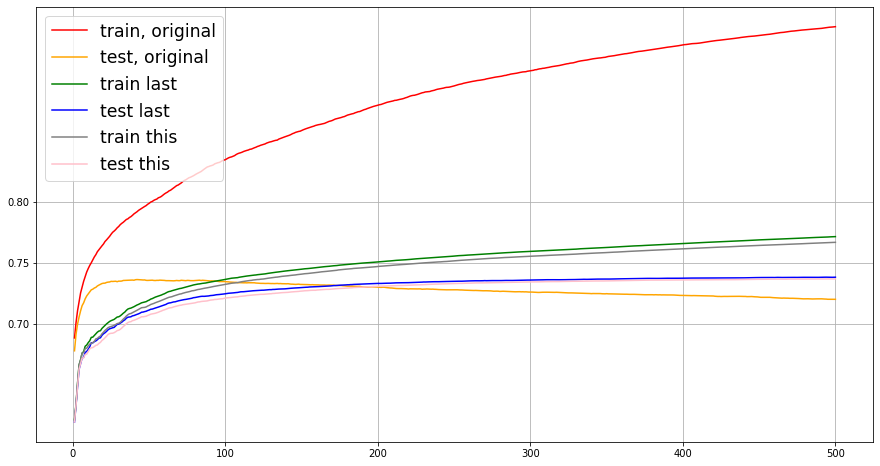

In [395]:
dfull = xgb.DMatrix(X,y)
param1 = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 4,
         'lambda': 1,
         'gamma':0,
         'subsample': 1,
         'colsample_bytree': 1,
         'colsample_bylevel': 1,
         'colsample_bynode': 1,
         'min_child_weight': 2,
         'eta': 0.3,
         'seed': 0,
         'silent': 1,
         'n_fold': 5,
         'scale_pos_weight':1}
num_round = 500

time0 = time()
cvResult = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

fig, ax = plt.subplots(1,figsize=(15,8))
ax.grid()
ax.plot(range(1,(num_round+1)), cvResult.iloc[:,0], c='r', label='train, original')
ax.plot(range(1,(num_round+1)), cvResult.iloc[:,2], c='orange', label='test, original')

params2 = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 1,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 2,
         'eta': 0.1,
         'seed': 0,
         'silent': 1,
         'scale_pos_weight':5}

params3 = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 1,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 2,
         'eta': 0.1,
         'seed': 10,
         'silent': 1,
         'scale_pos_weight':3}
time0 = time()
cvResult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0 = time()
cvResult3 = xgb.cv(param3, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

ax.plot(range(1,(num_round+1)), cvResult2.iloc[:,0], c='green', label='train last')
ax.plot(range(1,(num_round+1)), cvResult2.iloc[:,2], c='blue', label='test last')


ax.plot(range(1,(num_round+1)), cvResult3.iloc[:,0], c='grey', label='train this')
ax.plot(range(1,(num_round+1)), cvResult3.iloc[:,2], c='pink', label='test this')
ax.legend(fontsize='xx-large')
plt.yticks([0.7,0.75,0.8])
plt.show()

In [393]:
(y==1).sum()/(y==0).sum()

0.2890862124636745

In [275]:
params = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 30,
         'gamma':0,
         'subsample': 0.5,
         'colsample_bytree': 1,
         'colsample_bylevel': 0.5,
         'colsample_bynode': 0.5,
         'min_child_weight': 1,
         'eta': 0.05,
         'seed': 0,
         'silent': 1,
         'n_fold': 5,
         'scale_pos_weight':1}
num_round = 300

In [372]:
params1 = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 1,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 2,
         'eta': 0.05,
         'seed': 0,
         'silent': 1,
         'scale_pos_weight':5}
num_round = 500

In [373]:
bst = xgb.train(params1, dtrain, num_round)
preds = bst.predict(dtest)

In [374]:
roc_auc_score(Ytest, preds)

0.7357416673129318

In [375]:
names = ["negative vs positive: 3",
         "negative vs positive: 5",
         "negative vs positive: 8"]
scale_pos_weight = [3,5,8]

In [290]:
from sklearn.metrics import accuracy_score as acc, recall_score as recall, roc_auc_score as auc

for name, i in zip(names, scale_pos_weight):
    params1 = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 1,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 2,
         'eta': 0.1,
         'seed': 0,
         'silent': 1,
         'scale_pos_weight':i}
    bst = xgb.train(params, dtrain, num_round)
    preds = bst.predict(dtest)
    ypreds = preds.copy()
    ypreds[preds > 0.5] = 1
    ypreds[ypreds!=1] = 0
    print('{}'.format(name))
    print('\tAccuracy:{}'.format(acc(Ytest, ypreds)))
    print('\tRecall:{}'.format(recall(Ytest, ypreds)))
    print('\tAUC:{}'.format(auc(Ytest, preds)))

negative vs positive: 3
	Accuracy:0.7951072889705268
	Recall:0.23416080029640607
	AUC:0.7351013456877395
negative vs positive: 5
	Accuracy:0.7951072889705268
	Recall:0.23416080029640607
	AUC:0.7351013456877395
negative vs positive: 8
	Accuracy:0.7951072889705268
	Recall:0.23416080029640607
	AUC:0.7351013456877395


In [376]:
params_ = {'booster': 'gbtree',
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'max_depth': 3,
         'lambda': 1,
         'subsample': 0.75,
         'colsample_bytree': 0.75,
         'min_child_weight': 2,
         'eta': 0.05,
         'seed': 0,
         'silent': 1,
         'scale_pos_weight':5}
num_round = 500

In [377]:
bst = xgb.train(params_, dtrain, num_round)

In [378]:
import joblib

joblib.dump(bst, './训练数据集1/xgboost-fintech-joblib.dat')

['./训练数据集1/xgboost-fintech-joblib.dat']

In [379]:
loaded_model_joblib = joblib.load('./训练数据集1/xgboost-fintech-joblib.dat')
preds = loaded_model_joblib.predict(dtest)

auc(Ytest, preds)

0.7357416673129318

In [384]:
data_test_.pg_times.fillna(data_train_.pg_times.mode()[0], inplace=True)

In [385]:
test_data_feature = data_test_.drop(['id'], axis=1)
user_id = data_test_['id']
test_data_feature.shape

(6000, 46)

In [386]:
dtest_a = xgb.DMatrix(test_data_feature)

In [387]:
data_test_['preds'] = loaded_model_joblib.predict(dtest_a)

In [388]:
output_a = data_test_.loc[:,['id', 'preds']]

In [389]:
output_a.shape

(6000, 2)

In [390]:
output_a.to_csv('./训练数据集1/submit_a_txt.txt', sep='\t', index=False, encoding='utf8')